# Project 1: Classify Images of Road Traffic Signs

### Objective
-  Identify and classify images of road traffic signs to enhance navigation systems and improve road safety

### **Dataset**

Source: Belgium Traffic Sign Classification Benchmark, German TSC dataset

Input variables:

Output variable (desired target):

# Table of Contents
* 1. Import Libraries
* 2. Process the dataset
* 3. Exploratory Data Analysis (EDA)
  - 3.1 Visualise sample images according to shape and type
  - 3.2 Data Distribution
* 4. Data Splitting
* 5. Data Modelling
  - 5.1 Baseline Model: MLP NN
    - Model 1.1: Shape classification using MLP NN
    - Model 1.2: Type classification using MLP NN
    - Model 1.3: Combined Model using MLP NN
  - 5.2 Advanced Model: CNN VGG
    - Model 2.1: Shape classification using CNN
    - Model 2.2: Type
classification using CNN
  - Data Augmentation
* 6. Testing the model
* 7. Conclusion
* 8. Reference

## 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import cv2
import tensorflow as tf

# show better graph
%matplotlib inline

In [2]:
from google.colab import drive
drive .mount('/content/drive')

Mounted at /content/drive


#### Connect to the dataset file from google drive

In [3]:
!cp /content/drive/'My Drive'/Assignment2/trafficsigns_dataset.zip .
!cp /content/drive/'My Drive'/Assignment2/trafficsigns_dataset_testing.zip .

# !cp /content/drive/'My Drive'/COSC2673/Assignments/Assignment2/trafficsigns_dataset.zip .
# !cp /content/drive/'My Drive'/COSC2673/Assignments/Assignment2/trafficsigns_dataset_testing.zip .

Unzip the dataset

In [4]:
import zipfile
with zipfile.ZipFile('trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
with zipfile.ZipFile('trafficsigns_dataset_testing.zip', 'r') as zip_ref_test:
    zip_ref_test.extractall('./')

## 2. Process the dataset
Collect Image Files
- Function to traverse directories recursively and collect image files from the offered dataset and additional dataset for testing

In [5]:
def collect_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_files.append(os.path.join(root, file))
    return image_files

In [6]:
all_image_files = collect_image_files('./trafficsigns_dataset')
all_test_image = collect_image_files('./trafficsigns_dataset_testing')

Create a DataFrame with image file paths in a column named 'image_path'

In [7]:
df = pd.DataFrame({'image_path': all_image_files})
df_test = pd.DataFrame({'image_path': all_test_image})

To encode the traffic sign shapes and types

In [8]:
trafficsigns_shapes = {'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}
trafficsigns_types = {'rightofway': 0, 'stop': 1, 'bicycle': 2, 'limitedtraffic': 3, 'noentry': 4, 'noparking': 5,
                      'roundabout':6, 'speed': 7, 'trafficdirective': 8, 'traveldirection': 9, 'continue': 10,
                      'crossing': 11,  'laneend': 12, 'parking': 13, 'giveway': 14, 'warning': 15}

This project involves **multi-class image classification** and features traffic signs categorised into 5 shape classes and 16 type classes, with each image being classified into one of these categories

In [9]:
def assign_class_label(image_path):
    # Split the image path by '/'
    parts = image_path.split('/')

    # Extract shape and type from the parts
    shape = parts[-3]
    trafficsign_type = parts[-2]

    # Map shape and type to corresponding class labels using the dictionaries
    shape_label = trafficsigns_shapes.get(shape, -1)  # -1 if shape not found in dictionary
    type_label = trafficsigns_types.get(trafficsign_type, -1)  # -1 if type not found in dictionary

    # Return a tuple of shape label and type label
    return (shape_label, type_label)


- Get the dataframe with image_path, shape_label and type_label

In [10]:
df['shape_label'], df['type_label'] = zip(*df['image_path'].apply(assign_class_label))
df_test['shape_label'], df_test['type_label'] = zip(*df_test['image_path'].apply(assign_class_label))

In [11]:
print(f"Shape of offered dataset: {df.shape}.\n Shape of additional dataset: {df_test.shape}")

Shape of offered dataset: (3699, 3).
 Shape of additional dataset: (2234, 3)


In [12]:
df.head()

,image_path,shape_label,type_label
0,./trafficsigns_dataset/hex/stop/00715_00002.png,1,1
1,./trafficsigns_dataset/hex/stop/01162_00000.png,1,1
2,./trafficsigns_dataset/hex/stop/01920_00000.png,1,1
3,./trafficsigns_dataset/hex/stop/01920_00001.png,1,1
4,./trafficsigns_dataset/hex/stop/01832_00002.png,1,1


In [13]:
df_test.head()

,image_path,shape_label,type_label
0,./trafficsigns_dataset_testing/hex/stop/01992_...,1,1
1,./trafficsigns_dataset_testing/hex/stop/02380_...,1,1
2,./trafficsigns_dataset_testing/hex/stop/00148_...,1,1
3,./trafficsigns_dataset_testing/hex/stop/02042_...,1,1
4,./trafficsigns_dataset_testing/hex/stop/00343_...,1,1


## 3. Exploratory Data Analysis (EDA)

## 3.1 Visualise sample images according to shape and type

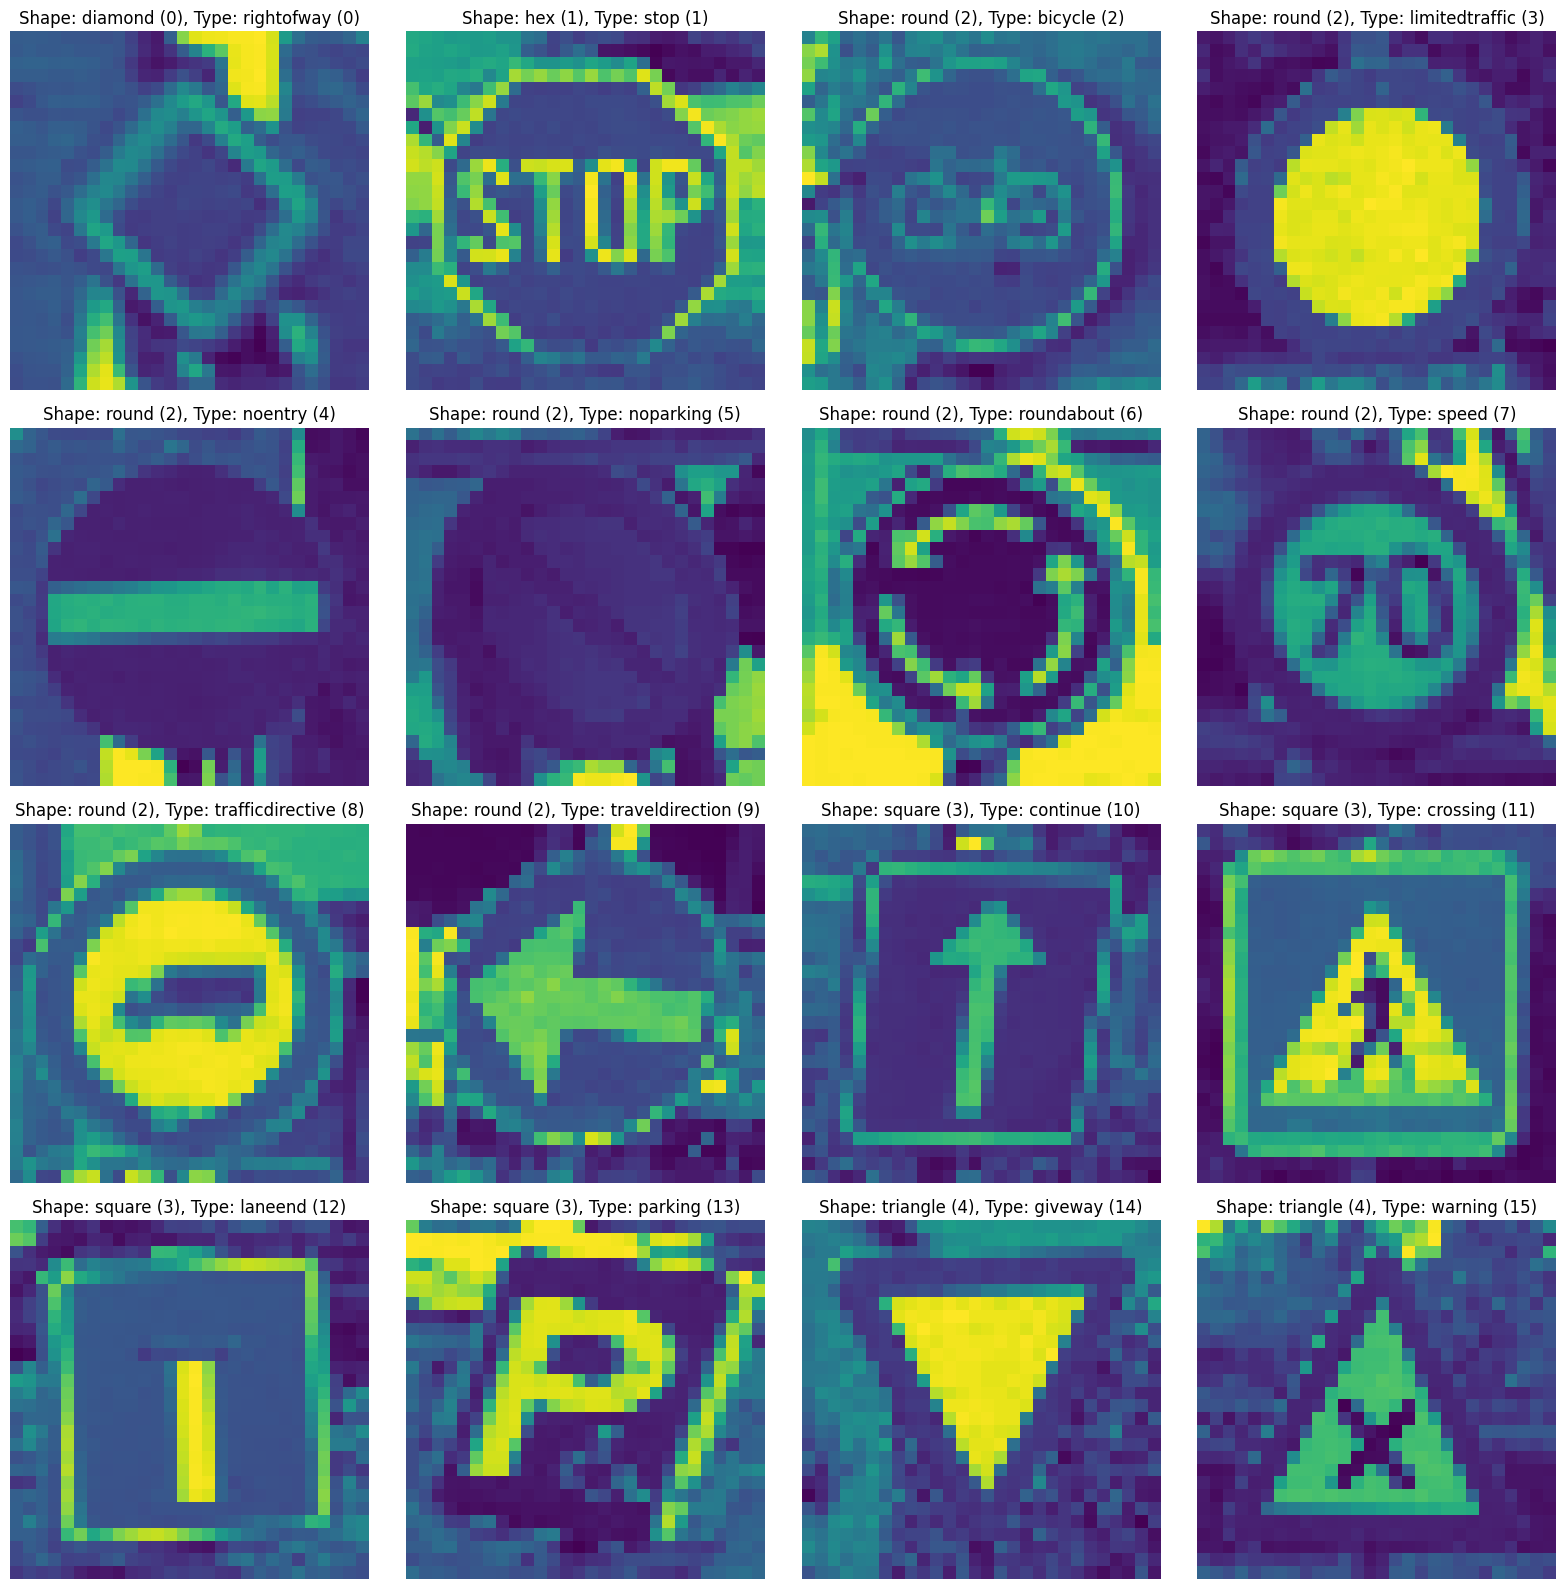

In [14]:
from matplotlib.pyplot import imread
import imageio

df['class_combo'] = df[['shape_label', 'type_label']].apply(tuple, axis=1)

# Reverse dictionaries to map labels back to names
shape_names = {v: k for k, v in trafficsigns_shapes.items()}
type_names = {v: k for k, v in trafficsigns_types.items()}

# Group by this new combo and pick the first image from each group
grouped = df.groupby('class_combo').first().reset_index()

# Visualization
plt.figure(figsize=(16, 16))
for i, row in enumerate(grouped.itertuples(), 1):
    plt.subplot(4, 4, i)  # Adjust grid size based on the number of unique class combinations
    image_path = os.path.join(os.getcwd(), row.image_path)
    image = imread(image_path)
    # Look up the shape and type names using the reverse dictionaries
    shape_name = shape_names.get(row.shape_label, "Unknown")
    type_name = type_names.get(row.type_label, "Unknown")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Shape: {shape_name} ({row.shape_label}), Type: {type_name} ({row.type_label})", fontsize=12)

plt.tight_layout()
plt.show()

## 3.2 Distribution of the dataset

<ipython-input-15-2dc661fc10c5>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(shape_labels, rotation=45, ha='right')
<ipython-input-15-2dc661fc10c5>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(type_labels, rotation=45, ha='right')


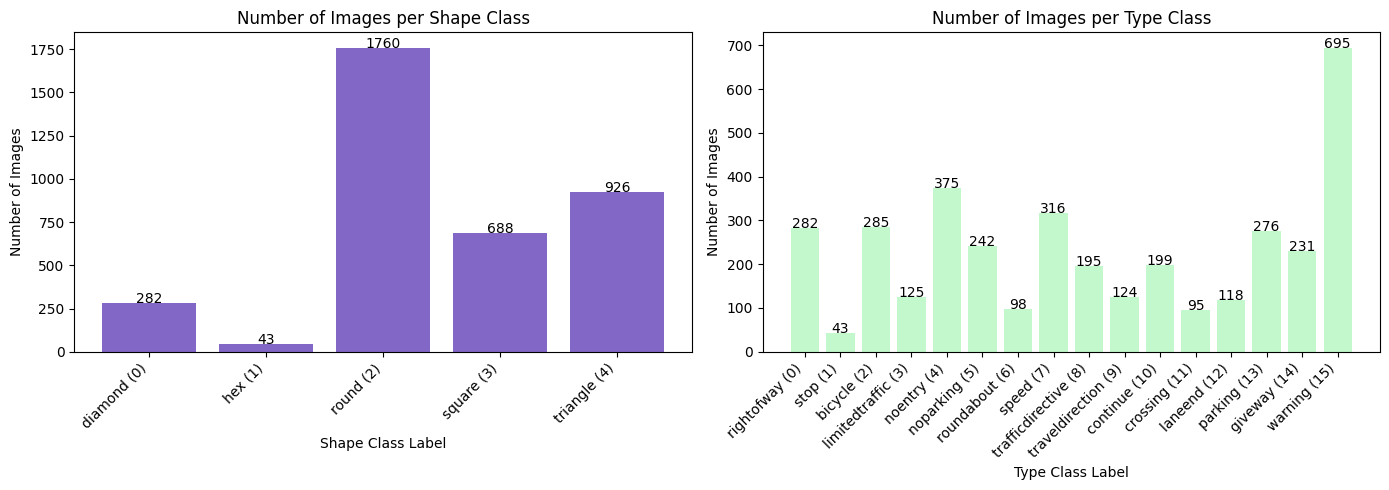

In [15]:
import matplotlib.pyplot as plt


# Convert index to label name for shapes
shape_labels = [f'{k} ({v})' for k, v in sorted(trafficsigns_shapes.items(), key=lambda item: item[1])]
# Convert index to label name for types
type_labels = [f'{k} ({v})' for k, v in sorted(trafficsigns_types.items(), key=lambda item: item[1])]

# Calculate the count of each class label for shape and type
shape_counts = df['shape_label'].value_counts().sort_index()
type_counts = df['type_label'].value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Bar chart for shape labels
axes[0].bar(shape_labels, shape_counts.values, color='#8367c7')
axes[0].set_title('Number of Images per Shape Class')
axes[0].set_xlabel('Shape Class Label')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticklabels(shape_labels, rotation=45, ha='right')
for index, value in enumerate(shape_counts.values):
    axes[0].text(index, value, str(value), ha='center')

# Bar chart for type labels
axes[1].bar(type_labels, type_counts.values, color='#C2F8CB')
axes[1].set_title('Number of Images per Type Class')
axes[1].set_xlabel('Type Class Label')
axes[1].set_ylabel('Number of Images')
axes[1].set_xticklabels(type_labels, rotation=45, ha='right')
for index, value in enumerate(type_counts.values):
    axes[1].text(index, value, str(value), ha='center')

plt.tight_layout()
plt.show()



#### Observations:
- Class imbalance: may affect the model performance. Further actions need to be taken to solve it

## 4. Data Spliting
- split offered dataset into 2 parts.
- Training set: 80%
- Validation set: 20%
- Testing set: the additional dataset

**Constants**

In [16]:
# height = 28 pixel, width = 28 pixel, channel = 1 (Grayscale)
INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM_SHAPE = 128
HIDDEN_LAYER_DIM_TYPE = 256
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES_SHAPE = 5  # Number of shape classes
OUTPUT_CLASSES_TYPE = 16  # Number of type classes

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
test_data = df_test

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))


Train data : 2959, Val Data: 740, Test Data: 2234


In [18]:
train_data.shape

(2959, 4)

In [19]:
# Print column names to verify
print(train_data.columns)


Index(['image_path', 'shape_label', 'type_label', 'class_combo'], dtype='object')


## Solve Class Imbalance with Data Augmentation (SMOTE--Oversampling)

Prepare data

#### Define a function to process images

In [20]:
def get_imgs_array(image_paths):
  images_data = []
  # Load all image
  for img_path in image_paths:
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      images_data.append(img)
  return np.array(images_data)

In [21]:
X = get_imgs_array(train_data['image_path'])


shape_labels_encoded = train_data['shape_label'].values
type_labels_encoded = train_data['type_label'].values

# Combine shape and type labels into a single multi-label format
def tuple_to_formatted_string(tup):
    return f"{tup[0]}_{tup[1]}"

combined_labels = np.array(train_data['class_combo'].apply(tuple_to_formatted_string))

X_reshape = X.reshape(X.shape[0], -1)


Initialize SMOTE

In [22]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

Oversampling for shape labels

In [23]:
X_resampled_shape, y_resampled_shape = smote.fit_resample(X_reshape, shape_labels_encoded)
# X_resampled_shape = X_resampled_shape.reshape(X_resampled_shape.shape[0], *original_image_shape)
num_samples = X_resampled_shape.shape[0]
height = 28
width = 28
channel = 1

X_resampled_shape_reshaped = X_resampled_shape.reshape(num_samples, height, width, channel)

In [24]:
def check_oversampling_classes(resampled_label):
  unique_classes_resampled, counts_resampled = np.unique(resampled_label, return_counts=True)
  print("\nOversampled Class Distribution:")
  for cls, count in zip(unique_classes_resampled, counts_resampled):
      print(f"Class {cls}: {count} samples")

check_oversampling_classes(y_resampled_shape)


Oversampled Class Distribution:
Class 0: 1414 samples
Class 1: 1414 samples
Class 2: 1414 samples
Class 3: 1414 samples
Class 4: 1414 samples


Oversampling for shape and type labels

In [25]:
X_resampled_shape_type, combined_labels_resampled = smote.fit_resample(X_reshape, combined_labels)
print(X_resampled_shape_type.shape)
num_samples = X_resampled_shape_type.shape[0]

X_resampled_shape_type = X_resampled_shape_type.reshape(num_samples, height, width, channel)
print(X_resampled_shape_type.shape)
shape_labels_resampled, type_labels_resampled = zip(*[label.split('_') for label in combined_labels_resampled])

# Convert the recovered labels back to numpy arrays
shape_labels_resampled = np.array(shape_labels_resampled)
type_labels_resampled = np.array(type_labels_resampled)


(8816, 784)
(8816, 28, 28, 1)


In [26]:
print(len(X_resampled_shape_type))
print(len(shape_labels_resampled))
print(len(type_labels_resampled))

8816
8816
8816


In [27]:
check_oversampling_classes(combined_labels_resampled)


Oversampled Class Distribution:
Class 0_0: 551 samples
Class 1_1: 551 samples
Class 2_2: 551 samples
Class 2_3: 551 samples
Class 2_4: 551 samples
Class 2_5: 551 samples
Class 2_6: 551 samples
Class 2_7: 551 samples
Class 2_8: 551 samples
Class 2_9: 551 samples
Class 3_10: 551 samples
Class 3_11: 551 samples
Class 3_12: 551 samples
Class 3_13: 551 samples
Class 4_14: 551 samples
Class 4_15: 551 samples


## Prepare data for training models

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 64


Normalizes the pixel values of the images so that the model are on a similar scale, which can help with the convergence of the model during training.

##### prepare train data generator

In [29]:
# function to create image generator
def create_img_generator(x, y, class_num):
  y = to_categorical(y, num_classes=class_num)
  return datagen.flow(x=x, y=y, batch_size=batch_size)


train_generator_shape = create_img_generator(x=X_resampled_shape_reshaped, y=y_resampled_shape, class_num=OUTPUT_CLASSES_SHAPE)

train_generator_type = create_img_generator(x=X_resampled_shape_type, y=type_labels_resampled, class_num=OUTPUT_CLASSES_TYPE)


##### prepare validation data generator

In [30]:
def images_for_flow(image_array):
  num_samples = image_array.shape[0]
  return  image_array.reshape(num_samples, 28, 28, 1)

val_x = get_imgs_array(val_data['image_path'])
val_x = images_for_flow(val_x)
val_y_shape = val_data['shape_label']
val_y_type = val_data['type_label']


validation_generator_shape = create_img_generator(x=val_x, y=val_y_shape, class_num=OUTPUT_CLASSES_SHAPE)

validation_generator_type = create_img_generator(x=val_x, y=val_y_type, class_num=OUTPUT_CLASSES_TYPE)


In [31]:
type(val_y_shape[0])

numpy.int64

#### Custom Data generator for combined model

In [32]:
def create_img_combined_generator(x, y1, y2):
    num_samples = len(x)
    while True:
        indices = np.random.permutation(num_samples)
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            batch_x = x[batch_indices]
            batch_y1 = y1[batch_indices]
            batch_y2 = y2[batch_indices]
            yield (batch_x, {'shape_output': batch_y1, 'type_output': batch_y2})
label_df_train = pd.DataFrame({})

train_generator_shape_type = create_img_combined_generator(x=X_resampled_shape_type,
                                                   y1=shape_labels_resampled,
                                                   y2=type_labels_resampled)

val_generator_shape_type = create_img_combined_generator(x=val_x,
                                                   y1=val_y_shape,
                                                   y2=val_y_type)

Define a function to plot accuracy between validation data and train data

In [33]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')


#### Install Keras

To build an image classifier we make use of Tensorflow‘ s Keras API to build our model

In [34]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

#### Set up the layers
We will use the Sequential API to build models as it is the simplest. In a **Sequential** type, each layer takes the output from the previous layer and uses it as its input.
**Dense** layers in a neural network mean that every node in one layer is connected to all the nodes in the previous layer.

In [35]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.1 MB/s eta 0:00:00


## 5.1 Base Model - MLP Neural Network (for 2 tasks)




* **What is an MLP?**
  - A type of neural network with three or more layers: input, hidden, and output layers.
  - Fully connected: Each neuron in one layer connects to every neuron in the next layer.
  - Utilizes backpropagation for learning, adjusting weights to minimize output error.
* **Why choose an MLP as a baseline model?**
  - Simplicity: Easy to implement and requires less setup time.
  - Efficiency: Quick to train, providing fast initial results.
  - Low Resource Use: Less computationally intensive than more complex models.
  - Performance Benchmarking: Provides a reference point for evaluating more advanced models.
  - Data Requirements: Performs well with smaller datasets, ideal when large data is unavailable.
  - Interpretability: Simple architecture makes it easier to understand and deb

### **Model1.1 Baseline Model --- Traffic sign shape**

In [36]:
model_shape_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM_SHAPE, activation='relu', name='m1_shape_hidden1'),
    tf.keras.layers.Dense(units=64, activation='relu', name='m1_shape_hidden2'),
    tf.keras.layers.Dense(units=16, activation='relu', name='m1_shape_hidden3'),
    tf.keras.layers.Dense(units=OUTPUT_CLASSES_SHAPE, activation='softmax', name='m1_shape_output')
])

model_shape_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])

In [37]:
model_shape_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 m1_shape_hidden1 (Dense)    (None, 128)               100480    
                                                                 
 m1_shape_hidden2 (Dense)    (None, 64)                8256      
                                                                 
 m1_shape_hidden3 (Dense)    (None, 16)                1040      
                                                                 
 m1_shape_output (Dense)     (None, 5)                 85        
                                                                 
Total params: 109861 (429.14 KB)
Trainable params: 109861 (429.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


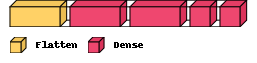

In [38]:
import visualkeras
# Generating the image for model architecture
visualkeras.layered_view(model_shape_1, scale_xy=2, scale_z=1, max_z=50, legend=True)


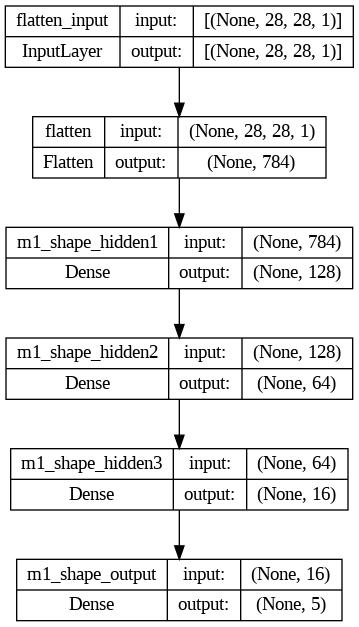

In [39]:
tf.keras.utils.plot_model(model_shape_1, show_shapes=True)


#### Train the base model for shape


train the base model for shape

In [40]:
history_1_shape = model_shape_1.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=50, verbose=0)

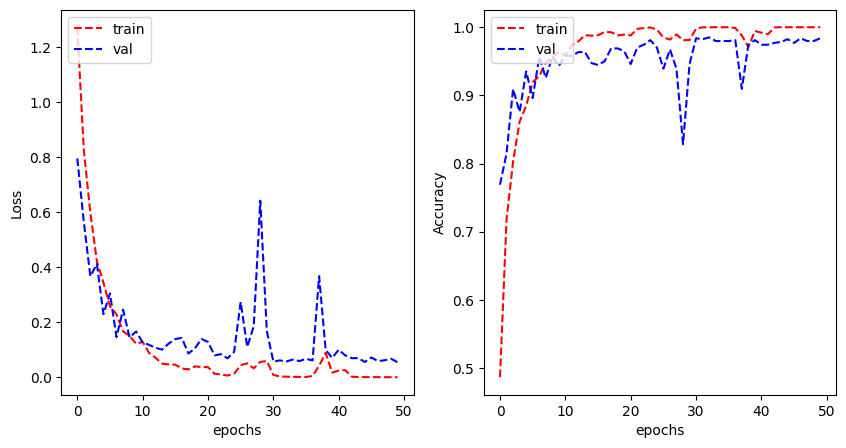

In [41]:
plot_learning_curve(history_1_shape.history['loss'], history_1_shape.history['val_loss'],
                    history_1_shape.history['categorical_accuracy'], history_1_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Function to plot **Confusion Matrix**

In [42]:
def plot_confusion_matrix(model, x_set, y_set, nr_classes, label_names):
  # filenames = test_image_generator.filenames
  # nb_samples = len(filenames)

  predictions = np.argmax(model.predict(x_set), axis=1)
  f1score = f1_score(y_set, predictions, average='weighted')
  print(f"F1 Score: {f1score:.2f}")
  accuracy = np.mean(predictions == y_set) * 100
  print(f"Accuracy: {accuracy:.2f}%")
  conf_matrix = confusion_matrix(y_set, predictions)

  nr_rows = conf_matrix.shape[0]
  nr_cols = conf_matrix.shape[1]
  plt.figure(figsize=(7,7), dpi=150)
  plt.imshow(conf_matrix, cmap=plt.cm.Greens)

  plt.title('Confusion Matrix', fontsize=16)
  plt.ylabel('Actual Labels', fontsize=12)
  plt.xlabel('Predicted Labels', fontsize=12)

  tick_marks = np.arange(nr_classes)
  plt.yticks(tick_marks, label_names)
  plt.xticks(tick_marks, label_names, rotation=45, ha='right')

  plt.colorbar()

  for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

  plt.show()


### use test data plot confusion matrix

In [43]:
test_x = get_imgs_array(test_data['image_path'])
test_x = images_for_flow(test_x)
test_y_shape = test_data['shape_label']
test_y_type = test_data['type_label']


test_generator_shape = create_img_generator(x=test_x, y=test_y_shape, class_num=OUTPUT_CLASSES_SHAPE)

test_generator_type = create_img_generator(x=test_x, y=test_y_type, class_num=OUTPUT_CLASSES_TYPE)


In [44]:
model_shape_1.evaluate(test_generator_shape)

35/35 [==============================] - 0s 5ms/step - loss: 0.0848 - categorical_accuracy: 0.9812


[0.08479460328817368, 0.9811996221542358]

70/70 [==============================] - 0s 2ms/step
F1 Score: 0.95
Accuracy: 94.54%


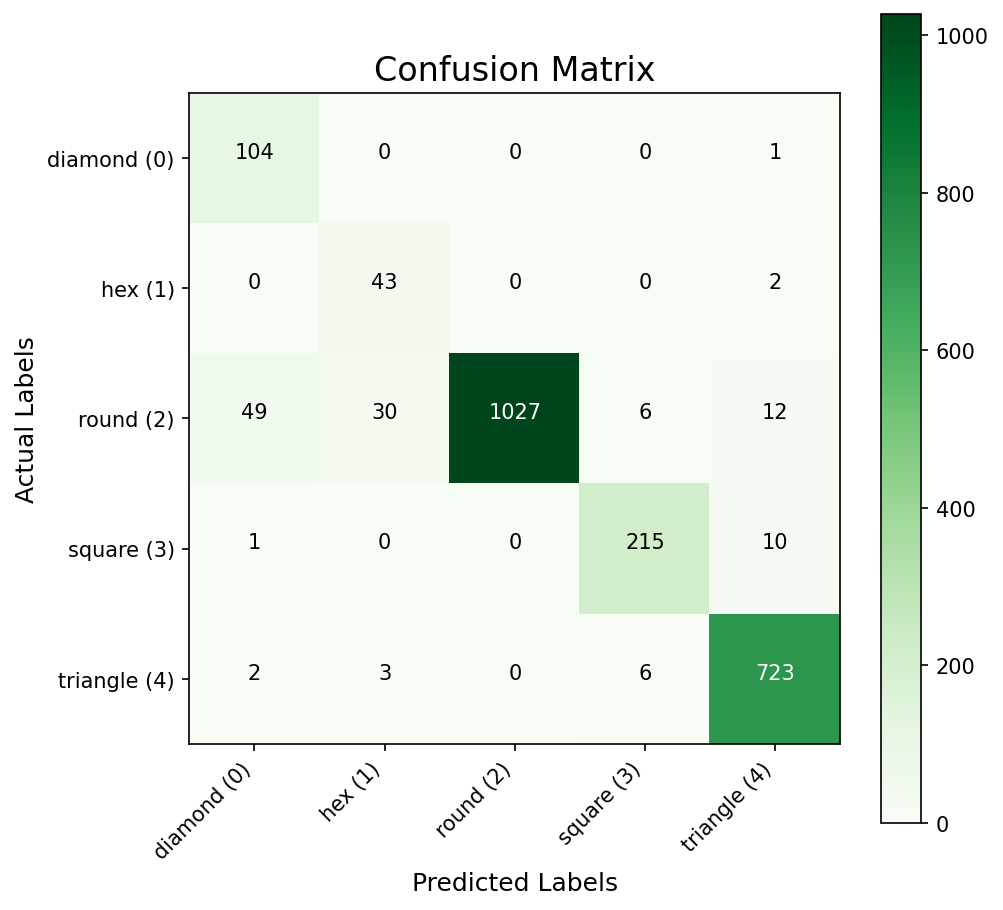

In [45]:
plot_confusion_matrix(model_shape_1, test_x, test_y_shape, OUTPUT_CLASSES_SHAPE, shape_labels)

In [46]:
from sklearn.metrics import classification_report

# Predict the labels for the test data
test_x = get_imgs_array(test_data['image_path'])
test_x = images_for_flow(test_x)
test_y_shape = test_data['shape_label']
test_y_type = test_data['type_label']

# Generate predictions for the shape classification model
predictions_shape = model_shape_1.predict(test_x)
y_pred_shape = np.argmax(predictions_shape, axis=1)

# Create a dictionary to map shape labels to their names
shape_names = {0: 'diamond', 1: 'hex', 2: 'round', 3: 'square', 4: 'triangle'}

# Print the classification report for shape classification
print("Shape Classification Report:")
print(classification_report(test_y_shape, y_pred_shape, target_names=[shape_names[i] for i in sorted(shape_names)]))



70/70 [==============================] - 0s 2ms/step
Shape Classification Report:
              precision    recall  f1-score   support

     diamond       0.67      0.99      0.80       105
         hex       0.57      0.96      0.71        45
       round       1.00      0.91      0.95      1124
      square       0.95      0.95      0.95       226
    triangle       0.97      0.99      0.98       734

    accuracy                           0.95      2234
   macro avg       0.83      0.96      0.88      2234
weighted avg       0.96      0.95      0.95      2234



### **Model1.2 Baseline Model --- traffic sign type**

In [47]:
model_type_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM_TYPE, activation='relu', name='m1_type_hidden1'),
    tf.keras.layers.Dense(units=128, activation='relu', name='m1_type_hidden2'),
    tf.keras.layers.Dense(units=64, activation='relu', name='m1_type_hidden3'),
    tf.keras.layers.Dense(units=OUTPUT_CLASSES_TYPE, activation='softmax', name='m1_output')
])

model_type_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])

In [48]:
model_type_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 m1_type_hidden1 (Dense)     (None, 256)               200960    
                                                                 
 m1_type_hidden2 (Dense)     (None, 128)               32896     
                                                                 
 m1_type_hidden3 (Dense)     (None, 64)                8256      
                                                                 
 m1_output (Dense)           (None, 16)                1040      
                                                                 
Total params: 243152 (949.81 KB)
Trainable params: 243152 (949.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


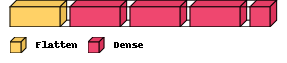

In [49]:
# Generating the image for model architecture
visualkeras.layered_view(model_type_1, scale_xy=2, scale_z=1, max_z=50, legend=True)

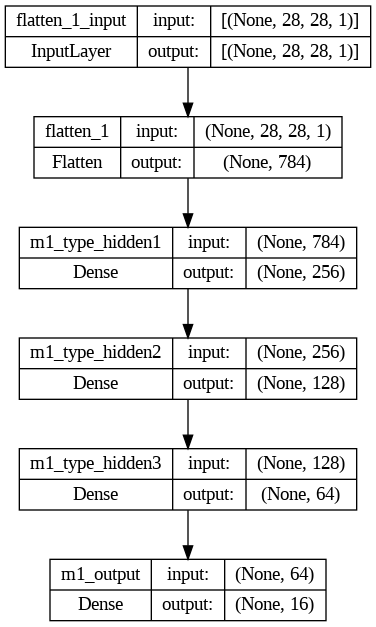

In [50]:
tf.keras.utils.plot_model(model_type_1, show_shapes=True)

### train the base model (type)

In [51]:
# %%time
history_1_type = model_type_1.fit(train_generator_type, validation_data = validation_generator_type, epochs=50, verbose=0)

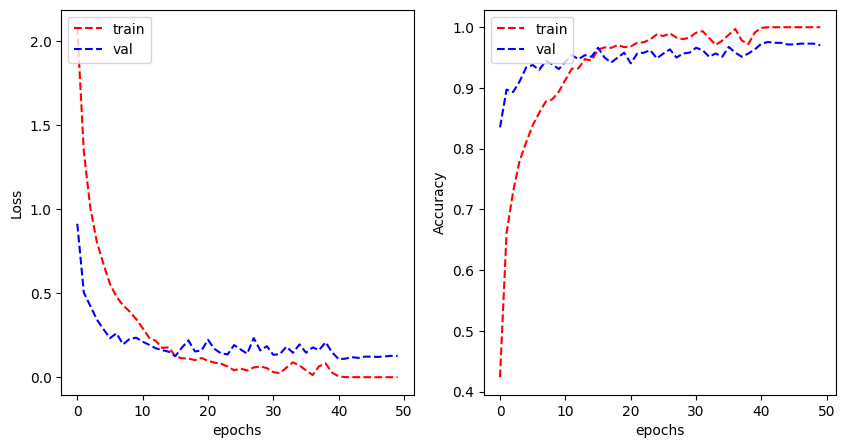

In [52]:
plot_learning_curve(history_1_type.history['loss'], history_1_type.history['val_loss'],
                    history_1_type.history['categorical_accuracy'], history_1_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

Observations:



# 5.2 Advanced Model: CNN model


CNNs are better suited for tasks like image recognition because they can exploit the spatial structure of the data through convolutional layers, reducing the number of parameters needed compared to fully connected layers in MLPs, making them more efficient and effective for tasks with spatial relationships, like images.



# VGG

The VGG architecture enhances basic CNNs through:
1. Uniformity: It consistently uses 3×3 convolutional filters and 2×2 max pooling, facilitating deeper network construction.
2. Depth: Deeper layers in VGG allow for more complex feature learning, improving image classification performance.
3. Robust Training: Strong initialisation, regularisation, and augmentation strategies improve training and prevent overfitting.



Observations:


Visually Interpreting the CNN's Inner Layers

We examine the internal layers of the CNN model to gain insights and interpret the significance of the features that the model identified while classifying a traffic sign

### Model 2.1 Shape classification using VGG CNN


In [53]:
# height = 28 pixel, width = 28 pixel
INPUT_DIM = (28,28,1)
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES_SHAPE = 5  # Number of shape classes
OUTPUT_CLASSES_TYPE = 16  # Number of type classes

In [54]:
import tensorflow as tf
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
])

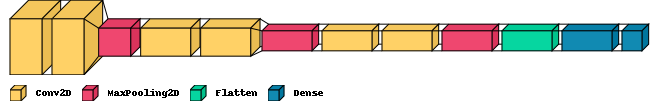

In [55]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_1, scale_xy=2, scale_z=1, max_z=50, legend=True)

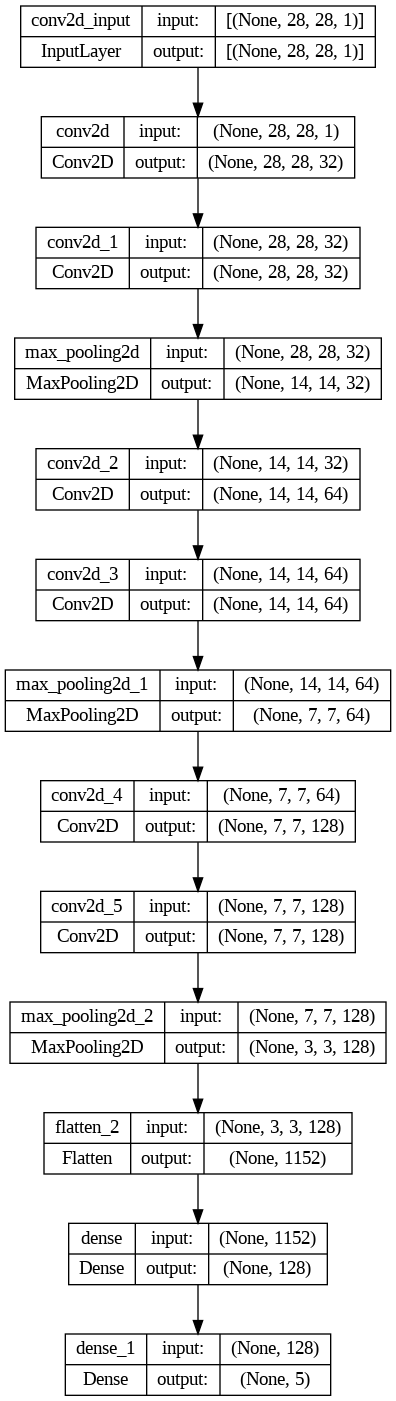

In [56]:
tf.keras.utils.plot_model(model_VGG_1, show_shapes=True)

In [57]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [58]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 1000
# #'image_path', 'shape_label', 'type_label'
# train_generator = train_datagen.flow_from_dataframe(
#         dataframe=train_data,
#         directory='./',
#         x_col="image_path",
#         y_col="shape_label_str",
#         target_size=(28, 28),
#         batch_size=batch_size,
#         class_mode='categorical')

# validation_generator = val_datagen.flow_from_dataframe(
#         dataframe=val_data,
#         directory='./',
#         x_col="image_path",
#         y_col="shape_label_str",
#         target_size=(28, 28),
#         batch_size=batch_size,
#         class_mode='categorical')

In [ ]:
history_VGG_1 = model_VGG_1.fit(
    train_generator_shape,
    validation_data=validation_generator_shape,
    epochs=50,
    verbose=0
)

In [ ]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [ ]:
# Assuming history_VGG_1.history['categorical_accuracy'] and
# history_VGG_1.history['val_categorical_accuracy'] are for shape classification:
shape_train_accuracies = history_VGG_1.history['categorical_accuracy']
shape_val_accuracies = history_VGG_1.history['val_categorical_accuracy']

# Calculate maximum and average accuracies for shape classification
max_shape_train_accuracy = max(shape_train_accuracies) * 100  # Convert to percentage
max_shape_train_epoch = shape_train_accuracies.index(max(shape_train_accuracies)) + 1  # Get epoch number (+1 for 1-based index)

average_shape_train_accuracy = (sum(shape_train_accuracies) / len(shape_train_accuracies)) * 100  # Convert to percentage

max_shape_val_accuracy = max(shape_val_accuracies) * 100  # Convert to percentage
max_shape_val_epoch = shape_val_accuracies.index(max(shape_val_accuracies)) + 1  # Get epoch number (+1 for 1-based index)

average_shape_val_accuracy = (sum(shape_val_accuracies) / len(shape_val_accuracies)) * 100  # Convert to percentage

print("Maximum Training Accuracy for Shape Classification: {:.2f}% at Epoch {}".format(max_shape_train_accuracy, max_shape_train_epoch))
print("Average Training Accuracy for Shape Classification: {:.2f}%".format(average_shape_train_accuracy))
print("Maximum Validation Accuracy for Shape Classification: {:.2f}% at Epoch {}".format(max_shape_val_accuracy, max_shape_val_epoch))
print("Average Validation Accuracy for Shape Classification: {:.2f}%".format(average_shape_val_accuracy))


### Model 2.2 Type classification using VGG CNN


In [ ]:
import tensorflow as tf


model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE),
])

In [ ]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_2, scale_xy=2, scale_z=1, max_z=50, legend=True)

In [ ]:
tf.keras.utils.plot_model(model_VGG_2, show_shapes=True)

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 1000
# #'image_path', 'shape_label', 'type_label'
# train_generator = train_datagen.flow_from_dataframe(
#         dataframe=train_data,
#         directory='./',
#         x_col="image_path",
#         y_col="type_label_str",
#         target_size=(28, 28),
#         batch_size=batch_size,
#         class_mode='categorical')

# validation_generator = val_datagen.flow_from_dataframe(
#         dataframe=val_data,
#         directory='./',
#         x_col="image_path",
#         y_col="type_label_str",
#         target_size=(28, 28),
#         batch_size=batch_size,
#         class_mode='categorical')

In [ ]:
history_VGG_2 = model_VGG_2.fit(
    train_generator_type,
    validation_data=validation_generator_type,
    epochs=25,
    verbose=0
)

In [ ]:
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_2.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [ ]:
# Assuming history_VGG_2.history['categorical_accuracy'] and
# history_VGG_2.history['val_categorical_accuracy'] are for type classification:
type_train_accuracies = history_VGG_2.history['categorical_accuracy']
type_val_accuracies = history_VGG_2.history['val_categorical_accuracy']

# Calculate maximum and average accuracies for type classification
max_type_train_accuracy = max(type_train_accuracies) * 100  # Convert to percentage
max_type_train_epoch = type_train_accuracies.index(max(type_train_accuracies)) + 1  # Get epoch number (+1 for 1-based index)
average_type_train_accuracy = (sum(type_train_accuracies) / len(type_train_accuracies)) * 100  # Convert to percentage

max_type_val_accuracy = max(type_val_accuracies) * 100  # Convert to percentage
max_type_val_epoch = type_val_accuracies.index(max(type_val_accuracies)) + 1  # Get epoch number (+1 for 1-based index)
average_type_val_accuracy = (sum(type_val_accuracies) / len(type_val_accuracies)) * 100  # Convert to percentage

print("Maximum Training Accuracy for Type Classification: {:.2f}% at Epoch {}".format(max_type_train_accuracy, max_type_train_epoch))
print("Average Training Accuracy for Type Classification: {:.2f}%".format(average_type_train_accuracy))
print("Maximum Validation Accuracy for Type Classification: {:.2f}% at Epoch {}".format(max_type_val_accuracy, max_type_val_epoch))
print("Average Validation Accuracy for Type Classification: {:.2f}%".format(average_type_val_accuracy))

## 6. Testing the final model

Display prediction result

show green color when correct & red when incorrect Actual Vs Predicted

In [ ]:
# # Data generator for test data
# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 1

# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='./',
#         x_col="image_path",
#         y_col=["Shape", "Type"],  # Assuming you want to predict both Shape and Type
#         target_size=(32, 32),
#         batch_size=batch_size,
#         class_mode='multi_output')  # Set to 'multi_output' to match your model's configuration

In [ ]:
# # Data generator for test data
# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 32  # or any batch size that fits your memory constraints

# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='./',
#         x_col="image_path",
#         y_col=["Shape", "Type"],  # Assuming you want to predict both Shape and Type
#         target_size=(28, 28),  # Ensure target size matches the input size of the network
#         batch_size=batch_size,
#         class_mode='multi_output')  # Set to 'multi_output' to match your model's configuration

# # Evaluate the model
# final_model.evaluate(test_generator)


In [ ]:
# ## still wrong

# import matplotlib.pyplot as plt
# import numpy as np

# # Increase the figure size and font size for better visibility
# plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
# font = {'family' : 'serif',
#         'weight' : 'bold',
#         'size'   : 12}  # Increase font size for better readability
# plt.rc('font', **font)

# batches = 0
# for x, y in test_generator:
#     batches += 1
#     y_hat = final_model.predict(x, verbose=0)
#     x = np.squeeze(x)
#     if batches < 5:
#         plt.subplot(1, 5, batches)
#         plt.imshow(x[0])  # Displaying the first image in the batch
#         shape_pred_index = np.argmax(y[0])
#         type_pred_index = np.argmax(y_hat[1])
#         try:
#             shape_label = shapes_inv[shape_pred_index]
#         except KeyError:
#             shape_label = 'Unknown Shape'
#         try:
#             type_label = types_inv[type_pred_index]
#         except KeyError:
#             type_label = 'Unknown Type'
#         plt.title("Actual-{}, Pred-{}".format(shape_label, type_label), pad=20)  # Add padding to avoid overlap
#     else:
#         break

#     plt.axis('off')
# plt.tight_layout()  # Adjust layout to fit everything nicely
# plt.show()


## 7. Conclusion


MLPs serve as a practical baseline for tasks like traffic sign classification due to their straightforward implementation and quick training. They are capable of modelling interactions between all input features, which is crucial for recognising complex patterns in the dataset. However, they are typically less effective than Convolutional Neural Networks (CNNs) for processing image data, as CNNs excel at capturing spatial hierarchies through their convolutional layers. This is evident from comparison tables where CNNs consistently show lower loss and higher accuracy.
In conclusion, we think Model 2 (CNN) is superior.


# 8. References

- https://www.linkedin.com/pulse/classify-traffic-signs-deep-learning-james-medel/
- https://github.com/james94/P3-Traffic-Sign-Classifier-CarND/blob/master/Traffic_Sign_Classifier_with_LeNet.ipynb
- https://www.youtube.com/watch?v=jztwpsIzEGc
- https://www.datacamp.com/tutorial/cnn-tensorflow-python